# Ejercicio Python de Regresión Logística
Realizaremos un ejercicio de prueba para comprender como funciona este algoritmo

In [1]:
# Importamos las librerías necesarias para el análisis de datos y machine learning
import pandas as pd  # Para manipulación de dataframes
import numpy as np   # Para operaciones numéricas
from sklearn import linear_model  # Para modelos lineales
from sklearn import model_selection  # Para división de datos y validación cruzada
from sklearn.metrics import classification_report  # Para reportes de clasificación
from sklearn.metrics import confusion_matrix  # Para matriz de confusión
from sklearn.metrics import accuracy_score  # Para calcular la precisión del modelo
import matplotlib.pyplot as plt  # Para crear gráficos
import seaborn as sns  # Para visualizaciones estadísticas
# %matplotlib inline

## Cargamos los datos de entrada del archivo csv

In [2]:
# Cargamos el dataset desde un archivo CSV que contiene datos de usuarios
dataframe = pd.read_csv("data/usuarios_win_mac_lin.csv")

# Definimos un diccionario para mapear los valores numéricos de clase a nombres legibles
clases = {
    0: 'Windows',  # Clase 0 representa usuarios de Windows
    1: 'Linux',    # Clase 1 representa usuarios de Linux
    2: 'Mac'       # Clase 2 representa usuarios de Mac
}

# Mostramos las primeras 5 filas del dataframe para entender la estructura de los datos
dataframe.head()

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


In [3]:
# Analizamos la distribución de las clases en el dataset
# normalize=True nos da las proporciones (porcentajes) en lugar de conteos absolutos
dataframe['clase'].value_counts(normalize=True)

clase
0    0.505882
2    0.258824
1    0.235294
Name: proportion, dtype: float64

In [4]:
# Obtenemos estadísticas descriptivas de todas las variables numéricas
# Esto incluye media, desviación estándar, mínimo, máximo y cuartiles
dataframe.describe()

,duracion,paginas,acciones,valor,clase
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,111.075729,2.041176,8.723529,32.676471,0.752941
std,202.453200,1.500911,9.136054,44.751993,0.841327
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,11.000000,1.000000,3.000000,8.000000,0.000000
50%,13.000000,2.000000,6.000000,20.000000,0.000000
75%,108.000000,2.000000,10.000000,36.000000,2.000000
max,898.000000,9.000000,63.000000,378.000000,2.000000


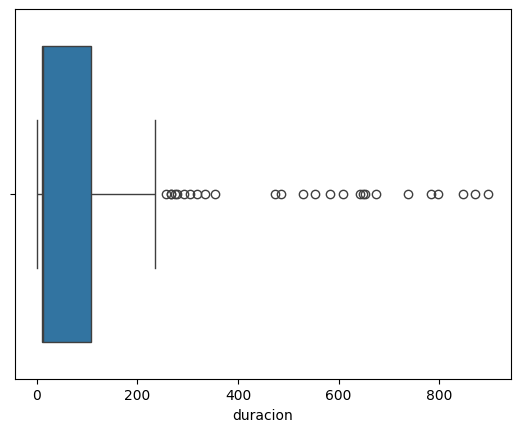

In [5]:
# Creamos un boxplot para visualizar la distribución de la variable 'duracion'
# Esto nos ayuda a identificar valores atípicos (outliers) y la distribución general
sns.boxplot(x= dataframe['duracion']);

**Interpretación del diagrama de caja (boxplot) y efecto de los outliers** (sin contexto)

El boxplot de la variable **duración** muestra que existen varios **valores atípicos (outliers)** muy alejados del resto de los datos.  
La mayoría de las observaciones se concentran por debajo de los 200, pero algunos valores superan los 400, 600 o incluso 900.

**Qué significan los outliers:**
- Representan observaciones que son **inusualmente altas** comparadas con el resto.
- Pueden deberse a **errores en los datos**, situaciones excepcionales o casos legítimos pero poco frecuentes.

**Problemas que pueden causar en el modelo:**
1. **Distorsión del entrenamiento:** Los outliers pueden influir demasiado en la estimación de los parámetros del modelo, especialmente en algoritmos sensibles a los valores extremos como la **regresión logística**, **SVM** o **KNN**.
2. **Escalado incorrecto:** Al aplicar técnicas de normalización o estandarización, los outliers pueden hacer que las demás observaciones parezcan muy pequeñas.
3. **Menor capacidad de generalización:** El modelo puede sobreajustarse a esos casos extremos y perder precisión en los datos típicos.
4. **Afectación de métricas:** Los errores causados por outliers pueden empeorar el desempeño medido en métricas como accuracy o F1-score.

**Posibles soluciones:**
- Aplicar una **transformación logarítmica** o de tipo **Box-Cox** para reducir la asimetría.
- Utilizar **modelos robustos** que toleren valores extremos.
- Detectar y **eliminar o recodificar** outliers si se identifican como errores de registro.
- Usar **escalado robusto** (por ejemplo, `RobustScaler` en scikit-learn) en lugar de `StandardScaler`.

**Interpretación general considerando los outliers en contexto**

Si observas los histogramas de las variables `duracion`, `paginas`, `acciones` y `valor`, se confirma que todas presentan una **distribución fuertemente asimétrica hacia la derecha** (right-skewed).  
Esto significa que la mayoría de los valores son bajos y solo unas pocas observaciones tienen valores muy altos.

**Conclusión respecto a los outliers:**
- Los valores extremos (outliers) detectados en el boxplot de `duracion` no son errores aislados, sino parte del comportamiento natural de los datos.  
- En contextos como análisis de comportamiento de usuarios o transacciones, este tipo de distribución es **normal**: pocos usuarios generan mucha actividad o duración.
- Por tanto, los outliers **no necesariamente son problemáticos**, pero siguen siendo observaciones que podrían afectar modelos sensibles a la escala.

**Qué hacer:**
- No es obligatorio eliminarlos, pero sí conviene aplicar **transformaciones logarítmicas o escalado robusto** para reducir su influencia.
- Si el modelo elegido es **no lineal** (por ejemplo, árboles de decisión o Random Forest), estos outliers no representan un gran problema, ya que estos algoritmos son menos sensibles a valores extremos.

**En resumen:**
Desde esta perspectiva, los outliers son coherentes con la naturaleza de los datos y no necesariamente "malos", aunque sigue siendo recomendable tratarlos o transformarlos para mejorar la estabilidad del modelo.



In [6]:
# Mostramos información general sobre el dataframe
# Incluye tipos de datos, valores no nulos y uso de memoria
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duracion  170 non-null    float64
 1   paginas   170 non-null    int64  
 2   acciones  170 non-null    int64  
 3   valor     170 non-null    int64  
 4   clase     170 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 6.8 KB


In [7]:
# Contamos cuántas observaciones hay en cada clase
# Esto nos ayuda a entender si tenemos un dataset balanceado o desbalanceado
print(dataframe.groupby('clase').size())

clase
0    86
1    40
2    44
dtype: int64




Conclusión:
Este conjunto no está perfectamente balanceado, ya que la clase 0 tiene el doble de ejemplos que las clases 1 y 2.
Sin embargo, no está extremadamente desbalanceado: sigue siendo una diferencia moderada (50% vs 25%).

## Visualizamos los datos

In [8]:
# Creamos una vista del dataframe sin la columna 'clase'
# Esto nos permite ver solo las variables predictoras (features)
dataframe.drop(columns=['clase'])

,duracion,paginas,acciones,valor
0,7.0,2,4,8
1,21.0,2,6,6
2,57.0,2,4,4
3,101.0,3,6,12
4,109.0,2,6,12
...,...,...,...,...
165,13.0,1,7,42
166,12.0,1,2,6
167,13.0,1,3,9
168,13.0,1,7,28


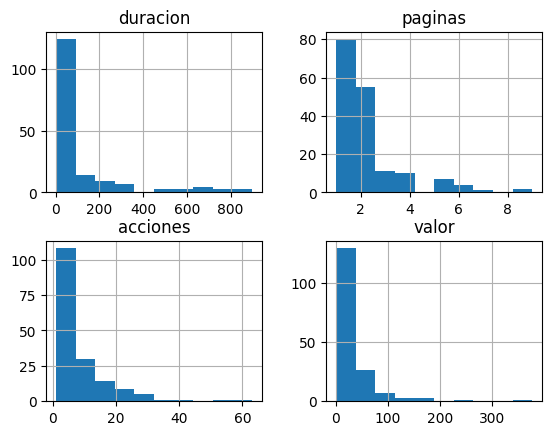

In [9]:
# Creamos histogramas para todas las variables numéricas (excepto 'clase')
# Esto nos ayuda a visualizar la distribución de cada variable predictora
dataframe.drop(columns=['clase']).hist()
plt.show()

| Variable     | Interpretación                                                                                                                                     |
| ------------ | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **duracion** | La mayoría de las sesiones (o eventos) duran poco tiempo, pero hay algunas que duran mucho más (hasta cerca de 900). Indica una gran variabilidad. |
| **paginas**  | La mayoría de los casos visitan 1 o 2 páginas, muy pocos visitan más de 5 o 6.                                                                     |
| **acciones** | Similar: la mayoría realiza pocas acciones (menos de 10), con unos pocos usuarios muy activos.                                                     |
| **valor**    | La mayoría de los valores (quizá monetarios o de interacción) son bajos, con unos pocos casos muy altos.                                           |


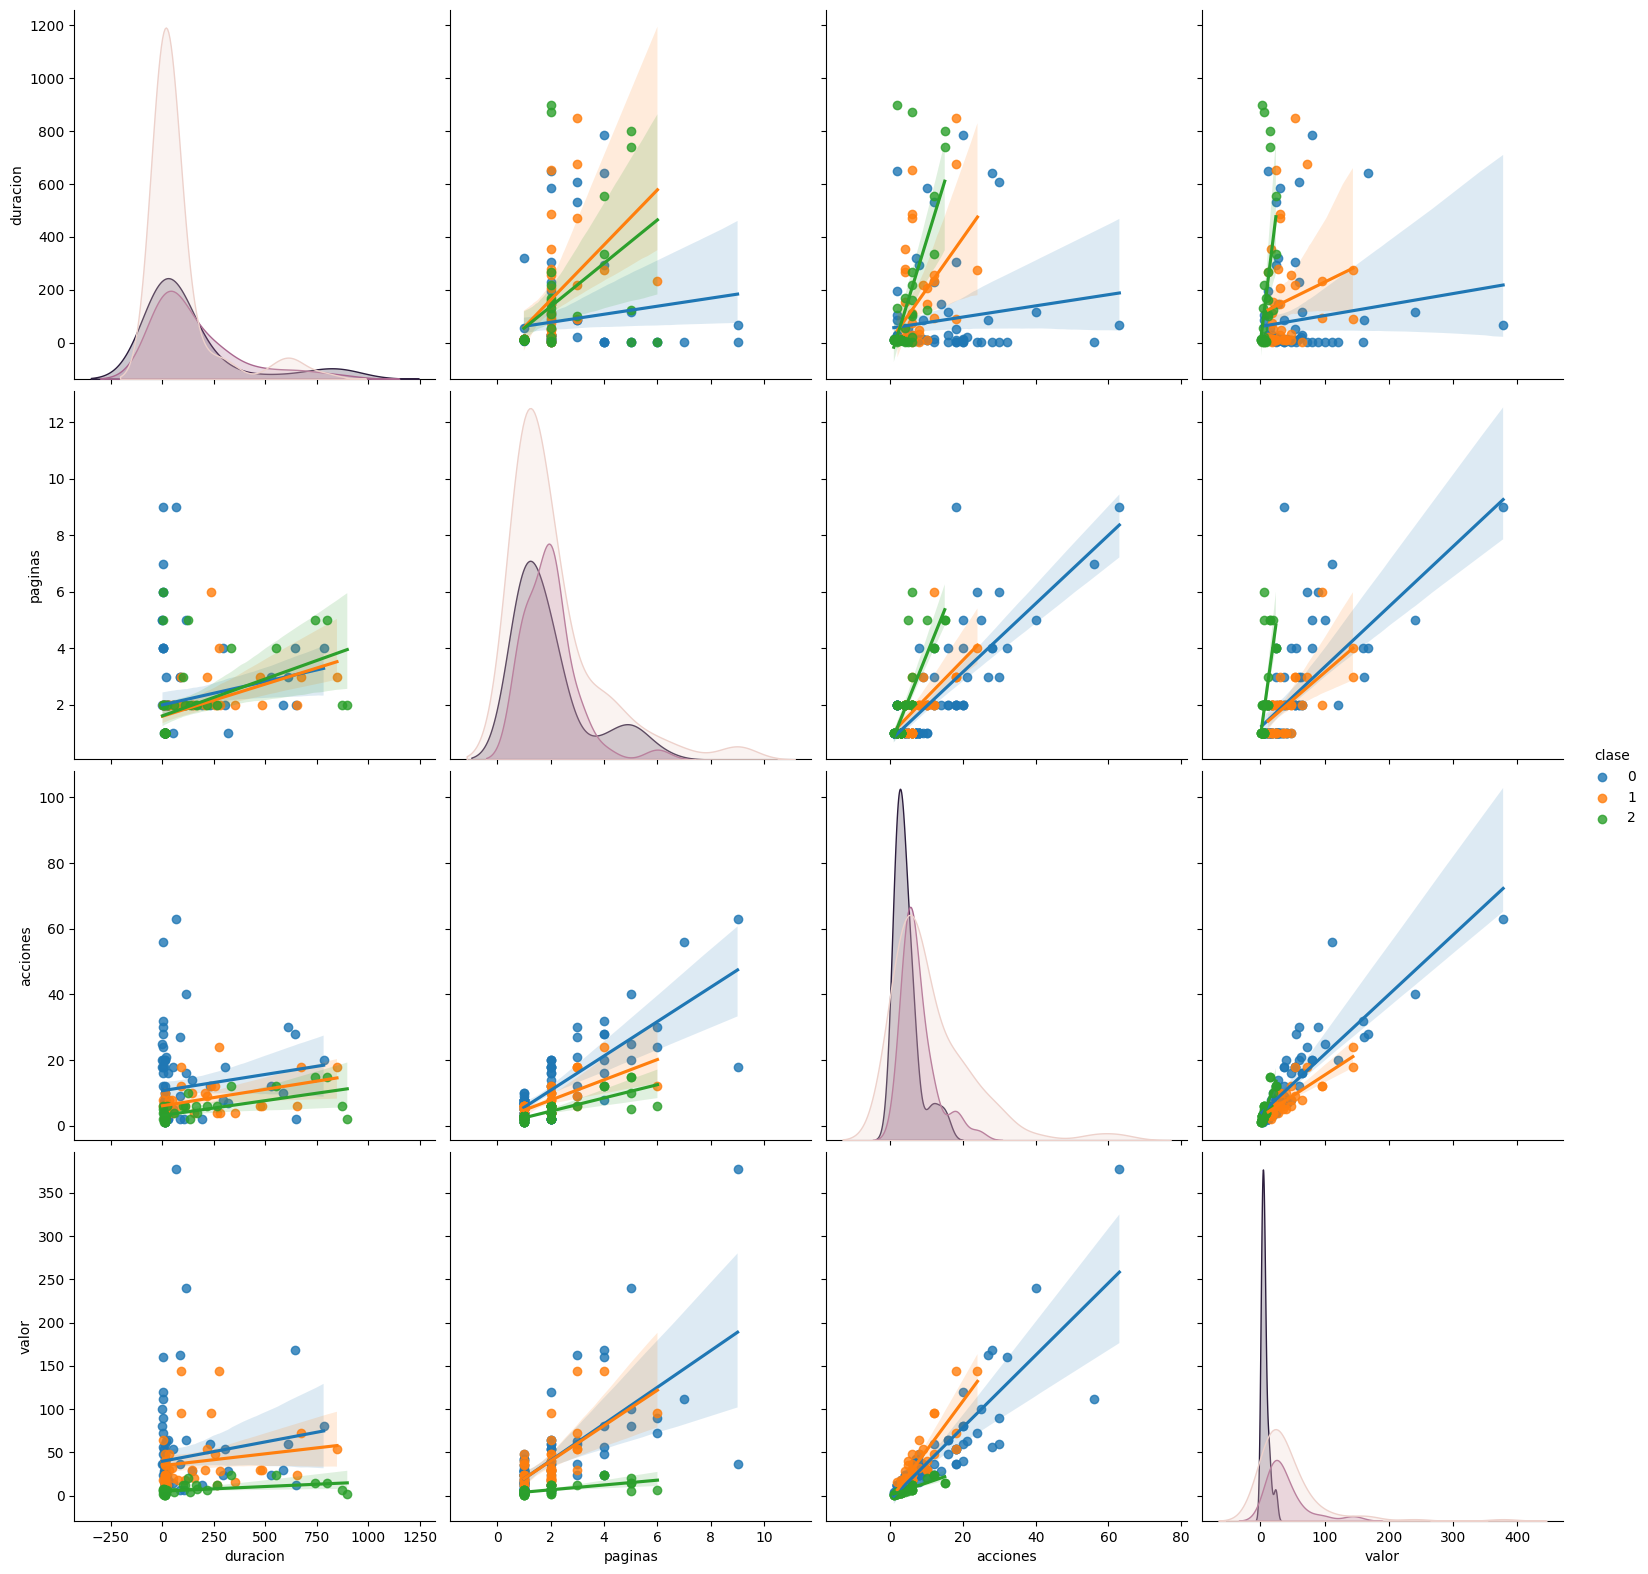

In [10]:
# Creamos un gráfico de pares (pairplot) para visualizar relaciones entre variables
# hue='clase' colorea los puntos según la clase, permitiendo ver patrones por grupo
# kind='reg' añade líneas de regresión a cada gráfico de dispersión
sns.pairplot(dataframe.dropna(),
            hue='clase',
            height=4,
            vars=["duracion", "paginas","acciones","valor"],
            kind='reg'); # "reg" de regresión lineal

**Propósito del Pair Plot en un modelo de clasificación**

Un **pair plot** (o gráfico de pares) se utiliza para **visualizar las relaciones entre todas las variables numéricas** de un conjunto de datos y cómo se distribuyen según las clases del modelo de clasificación.

**Objetivos principales:**

1. **Explorar relaciones entre variables:**
   Permite observar si existen **correlaciones** o patrones entre pares de variables (por ejemplo, si una aumenta cuando otra también lo hace).

2. **Visualizar la separación entre clases:**
   Al colorear los puntos según la clase, el gráfico muestra si las diferentes clases están **claramente separadas** en el espacio de las variables o si se **superponen**.  
   Esto ayuda a evaluar si el problema es **linealmente separable** o si se necesita un modelo más complejo.

3. **Detectar valores atípicos o distribuciones anómalas:**
   Los puntos alejados del resto pueden indicar **outliers** o comportamientos inusuales que podrían afectar el entrenamiento.

4. **Evaluar la relevancia de las variables:**
   Si una variable muestra una clara diferenciación entre clases, puede ser **muy informativa** para el modelo.  
   En cambio, si no hay separación visible, puede tener **bajo poder predictivo**.

**En resumen:**
El pair plot se utiliza en clasificación para **entender la estructura de los datos antes de entrenar el modelo**, identificar **relaciones entre variables**, **distinguir clases visualmente** y detectar **posibles outliers o redundancias** en las características.

**Resumen del pairplot:**
Las variables `duracion`, `paginas`, `acciones` y `valor` presentan distribuciones asimétricas hacia la derecha, con la mayoría de los valores concentrados en rangos bajos y algunos valores atípicos muy altos. Se observa una correlación positiva entre todas las variables: a mayor duración, tienden a aumentar las páginas visitadas, las acciones realizadas y el valor generado. Aunque las clases (0, 1 y 2) muestran cierta superposición, las clases 1 y 2 tienden a concentrarse en valores más altos en comparación con la clase 0. En general, las relaciones no son lineales, por lo que modelos no lineales podrían capturar mejor las diferencias entre clases.

## Creamos el modelo

In [11]:
# Preparamos los datos para el modelo de machine learning
# X contiene las variables predictoras (features) - todo excepto la columna 'clase'
X = np.array(dataframe.drop(columns=['clase']))
# y contiene la variable objetivo (target) - la columna 'clase' que queremos predecir
y = np.array(dataframe['clase'])

In [12]:
# Importamos el algoritmo de Regresión Logística desde scikit-learn
from sklearn.linear_model import LogisticRegression

In [17]:
# Creamos una instancia del modelo de Regresión Logística
# max_iter=1000 aumenta el número máximo de iteraciones para asegurar convergencia
model = LogisticRegression(max_iter=1000)
# Entrenamos el modelo con nuestros datos (X = features, y = target)
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


**Explicación de `max_iter` en la Regresión Logística**

En un modelo de Regresión Logística, el parámetro `max_iter` define el número máximo de iteraciones que el algoritmo de optimización puede ejecutar para ajustar los coeficientes del modelo.

Durante el entrenamiento, el algoritmo busca minimizar la función de costo (log-loss) ajustando los pesos paso a paso. Este proceso se repite hasta que el cambio entre iteraciones sea muy pequeño (convergencia) o hasta alcanzar el límite definido por `max_iter`.

Si el valor de `max_iter` es demasiado bajo, el modelo puede no converger y aparecerá una advertencia como:

En ese caso, se recomienda aumentar el número de iteraciones, por ejemplo de 100 a 1000, para permitir que el optimizador encuentre una mejor solución.

`ConvergenceWarning: lbfgs failed to converge (Increase the number of iterations)`.


Ejemplo:

```python
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


In [18]:
# Hacemos predicciones sobre el mismo conjunto de datos usado para entrenar
# Esto nos permite evaluar cómo está funcionando el modelo
predictions = model.predict(X)
print(predictions)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 2 2
 2 2 2 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 2 0
 0 1 1 1 0 0 0 0 0 0 0 0 2 1 0 0 0 0 1 0 0 2 0 2 1 0 0 0 0 0 0 0 0 0 0 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0]


In [19]:
# Obtenemos las probabilidades de predicción para cada clase
# (cada fila corresponde a una muestra y cada columna a una clase posible)
predicions_proba = model.predict_proba(X)

# Convertimos el resultado a un array de NumPy, redondeamos a 2 decimales
# y lo imprimimos en consola
print(np.round(np.array(predicions_proba), 2))


[[0.22 0.09 0.69]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.18 0.08 0.74]
 [0.28 0.1  0.62]
 [0.27 0.08 0.65]
 [0.05 0.05 0.91]
 [0.22 0.09 0.69]
 [0.09 0.06 0.84]
 [0.   0.   1.  ]
 [0.12 0.07 0.8 ]
 [0.32 0.09 0.59]
 [0.1  0.06 0.84]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.23 0.09 0.68]
 [0.   0.   1.  ]
 [0.65 0.34 0.01]
 [0.58 0.42 0.  ]
 [0.73 0.27 0.  ]
 [0.71 0.29 0.  ]
 [0.32 0.68 0.  ]
 [0.82 0.18 0.  ]
 [0.46 0.54 0.  ]
 [0.78 0.22 0.  ]
 [0.37 0.63 0.  ]
 [0.09 0.91 0.  ]
 [0.72 0.28 0.  ]
 [0.45 0.52 0.03]
 [0.5  0.5  0.  ]
 [0.35 0.65 0.  ]
 [0.22 0.78 0.  ]
 [0.26 0.74 0.  ]
 [0.22 0.78 0.  ]
 [0.64 0.36 0.  ]
 [0.01 0.   0.99]
 [0.03 0.02 0.95]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.81 0.19 0.  ]
 [0.61 0.39 0.  ]
 [0.54 0.46 0.  ]
 [0.23 0.77 0.  ]
 [0.68 0.32 0.  ]
 [0.28 0.72 0.  ]
 [0.57 0.43 0.  ]
 [0.41 0.59 0.  ]
 [0.76 0.24 0.  ]
 [0.99 0.01 0.  ]
 [0.77 0.23 0.  ]
 [0.78 0.22 0.  ]
 [0.97 0.03 0.  ]
 [0.99 0.01 0.  ]
 [0.91 0.09 0.  ]
 [0.98 0.0

In [20]:
# Calculamos la precisión (accuracy) del modelo
# Esto nos dice qué porcentaje de predicciones fueron correctas
model.score(X, y)

0.7764705882352941

In [21]:
# Mostramos qué clases puede predecir el modelo
# Debería mostrar [0, 1, 2] correspondientes a Windows, Linux y Mac
model.classes_

array([0, 1, 2])

# Validación del Modelo

**Validación Cruzada (Cross-Validation) y el parámetro `kfolds`**

La **validación cruzada** (cross-validation) es una técnica que permite evaluar el rendimiento de un modelo de manera más confiable, reduciendo el riesgo de sobreajuste (*overfitting*). En lugar de usar una única división de los datos en entrenamiento y prueba, la validación cruzada divide el conjunto de datos en varias partes o *folds* y realiza múltiples entrenamientos y evaluaciones.

**Cómo funciona:**
1. Los datos se dividen en *k* subconjuntos aproximadamente iguales, llamados *folds*.
2. El modelo se entrena *k* veces, utilizando en cada iteración *k-1* folds para entrenar y 1 fold diferente para validar.
3. Al final, se calcula el promedio de las métricas obtenidas en cada iteración (por ejemplo, el accuracy promedio).

**Ejemplo con k=5:**
- Se divide el dataset en 5 partes.
- El modelo se entrena 5 veces, usando 4 partes para entrenamiento y 1 diferente para validación en cada iteración.
- Se obtiene una medida promedio del rendimiento, que es más estable y generalizable que una sola partición.

**Parámetro `kfolds`:**
- Define el número de divisiones (*folds*) que se harán en la validación cruzada.
- Un valor común es `k=5` o `k=10`.
- Valores más altos proporcionan una estimación más precisa, pero aumentan el tiempo de cómputo, ya que el modelo se entrena más veces.

**Ejemplo en código:**
```python
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(max_iter=1000)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
resultados = cross_val_score(modelo, X, y, cv=kfold, scoring='accuracy')

print("Accuracy promedio:", resultados.mean())





**Resumen: Validación Cruzada y parámetro `kfolds`**

| Concepto | Descripción |
|-----------|-------------|
| **Validación cruzada (Cross-Validation)** | Técnica que evalúa el rendimiento del modelo dividiendo los datos en varios subconjuntos (*folds*) y repitiendo el entrenamiento varias veces. |
| **Objetivo principal** | Obtener una estimación más confiable del desempeño del modelo y reducir el riesgo de sobreajuste (*overfitting*). |
| **Parámetro `kfolds` o `n_splits`** | Indica el número de divisiones del dataset. Por ejemplo, `k=5` significa que los datos se dividen en 5 partes. |
| **Funcionamiento básico** | El modelo se entrena *k* veces, usando *k-1* folds para entrenar y 1 fold diferente para validar en cada iteración. |
| **Resultados** | Se calcula el promedio de la métrica (por ejemplo, accuracy) de las *k* ejecuciones para obtener una medida más estable. |
| **Valores comunes de `k`** | 5 o 10, según el tamaño del dataset y los recursos computacionales. |
| **Ventajas** | Mejora la estimación del rendimiento, reduce la varianza y aprovecha mejor los datos. |
| **Desventajas** | Aumenta el tiempo de entrenamiento, ya que el modelo se ajusta varias veces. |

In [22]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
# 20% de los datos se reservan para prueba (test_size=0.20)
# random_state=7 asegura que la división sea reproducible
validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=validation_size,
                                                                    random_state=seed)

In [23]:
# Nombre del modelo, solo para mostrar en los resultados
name = 'Logistic Regression'

# Definimos la validación cruzada (cross-validation) con 10 particiones (k=10)
# Esto significa que los datos se dividen en 10 partes: 
# en cada iteración, 9 partes se usan para entrenar y 1 para validar.
kfold = model_selection.KFold(n_splits=10)

# Ejecutamos validación cruzada usando accuracy como métrica
# - model: es el clasificador ya definido (ej. LogisticRegression)
# - X_train: variables predictoras de entrenamiento
# - Y_train: etiquetas de entrenamiento
# - cv=kfold: especifica el esquema de validación cruzada
# - scoring='accuracy': evalúa el modelo en términos de exactitud
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')

# Creamos un mensaje con:
# - el nombre del modelo
# - la media de los resultados de validación
# - la desviación estándar (para ver qué tan estables son los resultados)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())

# Mostramos todos los resultados de las 10 iteraciones
print(cv_results)

# Mostramos el resumen con media y desviación estándar
print(msg)


[0.78571429 0.64285714 0.71428571 0.71428571 0.71428571 0.71428571
 0.84615385 0.92307692 0.61538462 0.61538462]
Logistic Regression: 0.728571 (0.094186)


**Interpretación de los resultados de validación cruzada**

El modelo de Regresión Logística obtuvo una **precisión promedio de 0.7286 (72.9%)** con una **desviación estándar de 0.0942**.  
Esto indica que, en promedio, el modelo acierta aproximadamente en 7 de cada 10 predicciones.  
La desviación estándar moderada sugiere que el rendimiento varía algo entre las diferentes particiones, pero se mantiene relativamente estable.  
En general, el modelo muestra un desempeño aceptable y consistente en las distintas divisiones de los datos.


---

**GridSearchCV**

GridSearchCV es una técnica que se utiliza para encontrar automáticamente la mejor combinación de hiperparámetros de un modelo.  
Funciona probando todas las combinaciones posibles de los valores definidos por el usuario y evaluando el rendimiento de cada una mediante validación cruzada.

Durante el proceso, el modelo se entrena varias veces con diferentes configuraciones y se calcula el promedio de la métrica de evaluación (por ejemplo, accuracy) en cada caso.  
Finalmente, GridSearchCV devuelve los parámetros que lograron el mejor resultado y el valor promedio de desempeño asociado.

En resumen, GridSearchCV permite optimizar el modelo de forma sistemática y objetiva, aunque requiere más tiempo de cómputo porque entrena el modelo muchas veces.


In [24]:
# Realizamos una búsqueda en cuadrícula (Grid Search) para encontrar el mejor hiperparámetro C
# C es el parámetro de regularización - valores más altos = menos regularización
from sklearn.model_selection import GridSearchCV

# Definimos el rango de valores de C a probar (de 0.1 a 10 en pasos de 0.1)
params = {"C" : np.arange(0.1,10,0.1)}

# Creamos el objeto GridSearchCV que probará todos los valores de C
# cv=3 significa validación cruzada con 3 particiones
# verbose=3 muestra información detallada del proceso
gs = GridSearchCV(estimator=model, param_grid=params, cv=3, scoring='accuracy', verbose=3)
gs.fit(X_train, Y_train)

# Mostramos los mejores resultados encontrados
print(gs.best_estimator_)  # El modelo con los mejores parámetros
print(gs.best_score_)      # La mejor puntuación obtenida
print(gs.best_params_)     # Los mejores parámetros encontrados

Fitting 3 folds for each of 99 candidates, totalling 297 fits
[CV 1/3] END .............................C=0.1;, score=0.674 total time=   0.0s
[CV 2/3] END .............................C=0.1;, score=0.711 total time=   0.0s
[CV 3/3] END .............................C=0.1;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=0.2;, score=0.717 total time=   0.0s
[CV 2/3] END .............................C=0.2;, score=0.711 total time=   0.0s
[CV 3/3] END .............................C=0.2;, score=0.711 total time=   0.0s
[CV 1/3] END .............C=0.30000000000000004;, score=0.717 total time=   0.0s
[CV 2/3] END .............C=0.30000000000000004;, score=0.756 total time=   0.0s
[CV 3/3] END .............C=0.30000000000000004;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=0.4;, score=0.696 total time=   0.0s
[CV 2/3] END .............................C=0.4;, score=0.756 total time=   0.0s
[CV 3/3] END .............................C=0.4

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .............................C=2.7;, score=0.717 total time=   0.1s
[CV 2/3] END .............................C=2.7;, score=0.756 total time=   0.0s
[CV 3/3] END .............................C=2.7;, score=0.711 total time=   0.0s
[CV 1/3] END ..............C=2.8000000000000003;, score=0.717 total time=   0.0s
[CV 2/3] END ..............C=2.8000000000000003;, score=0.756 total time=   0.0s
[CV 3/3] END ..............C=2.8000000000000003;, score=0.711 total time=   0.0s
[CV 1/3] END ..............C=2.9000000000000004;, score=0.717 total time=   0.0s
[CV 2/3] END ..............C=2.9000000000000004;, score=0.756 total time=   0.0s
[CV 3/3] END ..............C=2.9000000000000004;, score=0.711 total time=   0.0s
[CV 1/3] END ..............C=3.0000000000000004;, score=0.717 total time=   0.0s
[CV 2/3] END ..............C=3.0000000000000004;, score=0.756 total time=   0.0s
[CV 3/3] END ..............C=3.0000000000000004;, score=0.711 total time=   0.0s
[CV 1/3] END ...............

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .............................C=5.4;, score=0.717 total time=   0.1s
[CV 2/3] END .............................C=5.4;, score=0.756 total time=   0.0s
[CV 3/3] END .............................C=5.4;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=5.5;, score=0.717 total time=   0.0s
[CV 2/3] END .............................C=5.5;, score=0.756 total time=   0.0s
[CV 3/3] END .............................C=5.5;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=5.6;, score=0.717 total time=   0.0s
[CV 2/3] END .............................C=5.6;, score=0.756 total time=   0.0s
[CV 3/3] END .............................C=5.6;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=5.7;, score=0.717 total time=   0.1s
[CV 2/3] END .............................C=5.7;, score=0.756 total time=   0.0s
[CV 3/3] END .............................C=5.7;, score=0.711 total time=   0.0s
[CV 1/3] END ...............

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .............................C=7.4;, score=0.717 total time=   0.1s
[CV 2/3] END .............................C=7.4;, score=0.778 total time=   0.0s
[CV 3/3] END .............................C=7.4;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=7.5;, score=0.717 total time=   0.0s
[CV 2/3] END .............................C=7.5;, score=0.778 total time=   0.0s
[CV 3/3] END .............................C=7.5;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=7.6;, score=0.717 total time=   0.1s
[CV 2/3] END .............................C=7.6;, score=0.778 total time=   0.0s
[CV 3/3] END .............................C=7.6;, score=0.711 total time=   0.0s
[CV 1/3] END .............................C=7.7;, score=0.717 total time=   0.0s
[CV 2/3] END .............................C=7.7;, score=0.778 total time=   0.0s
[CV 3/3] END .............................C=7.7;, score=0.711 total time=   0.0s
[CV 1/3] END ...............

In [38]:
# Entrenamos un nuevo modelo con los parámetros por defecto
#model = gs.best_estimator_  # Comentado: podríamos usar el mejor modelo del Grid Search
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [39]:
# Evaluamos el modelo en el conjunto de prueba (datos no vistos durante el entrenamiento)
# Esto nos da una estimación más realista del rendimiento del modelo
predictions = model.predict(X_test)
print(accuracy_score(Y_test, predictions))

0.8529411764705882


In [40]:
# Calculamos el porcentaje de acierto y error del modelo
acierto = accuracy_score(Y_test, predictions)
error = 1 - acierto  # El error es el complemento del acierto

# Mostramos los resultados en porcentajes redondeados a 2 decimales
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 85.29 %
Error: 14.71 %


## Resultados

In [41]:
# Importamos las métricas necesarias para evaluar el modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [42]:
# Calculamos la matriz de confusión que muestra las predicciones correctas e incorrectas
c_matrix = confusion_matrix(Y_test, predictions)

In [43]:
# Mostramos la matriz de confusión en formato numérico
# Filas = clases reales, Columnas = clases predichas
print(c_matrix)

[[16  0  2]
 [ 3  3  0]
 [ 0  0 10]]


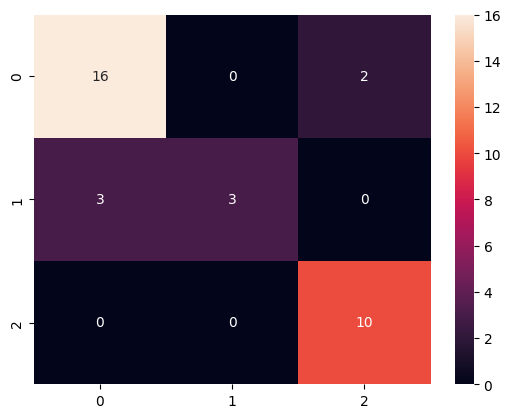

In [44]:
# Visualizamos la matriz de confusión como un mapa de calor (heatmap)
# annot=True muestra los números dentro de cada celda
import seaborn as sns
sns.heatmap(c_matrix, annot=True);

**Interpretación de la matriz de confusión**

La matriz de confusión muestra el desempeño del modelo al comparar las predicciones con las clases reales:

| Clase real | Predicha como 0 | Predicha como 1 | Predicha como 2 |
|-------------|----------------|----------------|----------------|
| **0** | 16 | 0 | 2 |
| **1** | 3 | 3 | 0 |
| **2** | 0 | 0 | 10 |

**Análisis:**
- La **clase 0** fue clasificada correctamente en 16 casos, con 2 errores que fueron confundidos con la clase 2.  
- La **clase 1** presenta el peor desempeño: solo 3 aciertos y 3 errores (predichos como clase 0).  
- La **clase 2** fue reconocida correctamente en los 10 casos, sin confusiones.

**Conclusión:**
El modelo clasifica correctamente la mayoría de las instancias de las clases 0 y 2, pero tiene dificultades para identificar la clase 1, que se confunde principalmente con la clase 0.  
En general, el rendimiento es aceptable, aunque se podría mejorar la discriminación de la clase 1 (por ejemplo, ajustando hiperparámetros, balanceando los datos o revisando las características usadas).


[Nice confusion matrix catalog visuals examples](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

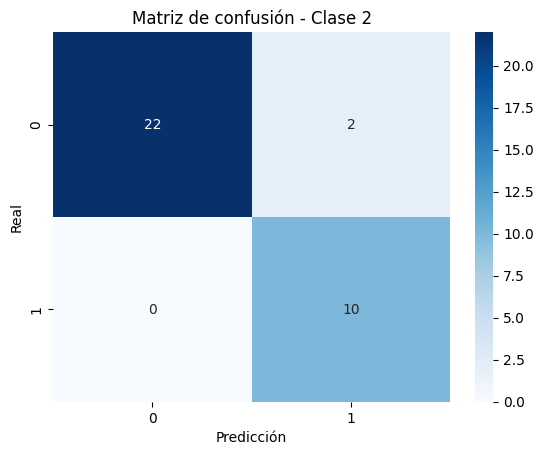

In [45]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos la matriz de confusión por cada clase
# Esto devuelve un array 3D: una matriz (2x2) por cada clase
mcm = multilabel_confusion_matrix(Y_test, predictions)

# Seleccionamos la matriz de confusión de la clase con índice 2 (la tercera clase)
matriz_clase_2 = mcm[2]

# Dibujamos un heatmap con anotaciones de los valores
sns.heatmap(matriz_clase_2, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Clase 2")
plt.show()

**Interpretación de la matriz de confusión - Clase 2**

| Clase real | Predicha como 0 | Predicha como 1 |
|-------------|----------------|----------------|
| **0** | 22 | 2 |
| **1** | 0 | 10 |

**Análisis:**
- El modelo predijo correctamente **22** casos de la clase 0 y **10** casos de la clase 1.
- Solo se produjeron **2 errores**, donde instancias reales de la clase 0 fueron clasificadas incorrectamente como clase 1.
- No hubo falsos negativos para la clase 1, lo que significa que el modelo identificó correctamente todos los casos positivos.

**Conclusión:**
El modelo muestra un desempeño **muy sólido** para esta clasificación binaria.  
La precisión y el recall para la clase 1 son altos, indicando que el modelo distingue bien entre ambas clases, con muy pocos errores de clasificación.


In [46]:
# Calculamos matrices de confusión multilabel (una por cada clase)
# Esto es útil para problemas de clasificación multiclase
multilabel_confusion_matrix(Y_test, predictions)

array([[[13,  3],
        [ 2, 16]],

       [[28,  0],
        [ 3,  3]],

       [[22,  2],
        [ 0, 10]]])

In [47]:
# Ejemplo de cálculo manual de recall para la clase 2
# Recall = Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)
10 / (0  + 10)

1.0

In [48]:
# Generamos un reporte completo de clasificación con métricas detalladas
# Incluye precision, recall, f1-score y support para cada clase
from sklearn.metrics import classification_report

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       1.00      0.50      0.67         6
           2       0.83      1.00      0.91        10

    accuracy                           0.85        34
   macro avg       0.89      0.80      0.81        34
weighted avg       0.87      0.85      0.84        34



**Explicación de las métricas de evaluación en un modelo de clasificación**

Las métricas **precision**, **recall**, **f1-score** y **accuracy** permiten evaluar el rendimiento de un modelo de clasificación comparando las predicciones con los valores reales.

| Métrica | Descripción | Interpretación |
|----------|-------------|----------------|
| **Precision (Precisión)** | Porcentaje de predicciones correctas dentro de las instancias clasificadas como una clase. | Mide cuántos de los elementos que el modelo predijo como positivos realmente lo eran. Alta precisión significa pocos falsos positivos. |
| **Recall (Exhaustividad o Sensibilidad)** | Porcentaje de verdaderos positivos detectados correctamente por el modelo. | Mide cuántos de los elementos realmente positivos fueron detectados. Alto recall significa pocos falsos negativos. |
| **F1-score** | Media armónica entre precisión y recall. | Equilibra ambas métricas; útil cuando hay desequilibrio entre clases. Un valor alto indica un buen balance entre precisión y recall. |
| **Support** | Número de instancias reales de cada clase en el conjunto de prueba. | Sirve para entender el peso que tiene cada clase en el cálculo de las métricas globales. |
| **Accuracy (Exactitud global)** | Proporción total de predicciones correctas entre todas las muestras. | Mide el desempeño general del modelo. En este caso, 0.85 significa que el modelo acierta el 85% de las veces. |
| **Macro avg** | Promedio simple de las métricas entre todas las clases. | Da el mismo peso a cada clase, sin importar cuántas instancias tenga. Útil cuando las clases están desbalanceadas. |
| **Weighted avg** | Promedio ponderado por el número de muestras de cada clase. | Refleja mejor el desempeño global cuando las clases tienen distinto tamaño. |

**Interpretación de los resultados:**
- El modelo tiene una **exactitud general del 85%**, lo cual indica un buen rendimiento.  
- La **clase 0** y la **clase 2** presentan buenos valores de precisión y recall, lo que significa que son bien clasificadas.  
- La **clase 1** tiene una precisión perfecta (1.00) pero un recall bajo (0.50), lo que indica que aunque el modelo casi no comete falsos positivos, deja sin identificar la mitad de los casos reales de esa clase.  
- En conjunto, el modelo funciona bien, pero sería conveniente mejorar la detección de la clase 1 para equilibrar el desempeño entre todas las clases.


**Análisis por clase:**
- **Clase 0:** Buen desempeño general, con alta precisión y recall.  
- **Clase 1:** Alta precisión (1.00) pero bajo recall (0.50), lo que significa que el modelo casi no se equivoca al predecir clase 1, pero deja escapar muchos casos que pertenecen a ella.  
- **Clase 2:** Excelente recall (1.00) y buen balance entre precisión y F1-score.

**Conclusión:**
El modelo muestra un rendimiento general bueno (**85% de exactitud**) y predice bien las clases 0 y 2. Sin embargo, necesita mejorar la detección de la **clase 1**, ya que identifica solo la mitad de sus casos reales. Ajustar el modelo o balancear los datos podría mejorar este comportamiento.


In [49]:
# Calculamos métricas globales usando promedio macro (sin considerar el soporte de cada clase)
# average='macro' da el mismo peso a todas las clases independientemente de su frecuencia
from sklearn.metrics import recall_score, precision_score

print("recall", recall_score(Y_test, predictions, average='macro'))
print("precision", precision_score(Y_test, predictions, average='macro'))

recall 0.7962962962962963
precision 0.8918128654970761


In [50]:
# Calculamos métricas globales usando promedio ponderado (considerando el soporte de cada clase)
# average='weighted' pondera las métricas según la frecuencia de cada clase en el dataset
print("recall", recall_score(Y_test, predictions, average='weighted'))
print("precision", precision_score(Y_test, predictions, average='weighted'))

recall 0.8529411764705882
precision 0.8673890608875129


# Clasificación de nuevos registros

In [51]:
# Creamos un nuevo registro para clasificar (simulando un nuevo usuario)
# Contiene las mismas variables que nuestros datos de entrenamiento
X_new = pd.DataFrame({'duracion': [8],
                     'paginas': [5],
                     'acciones': [5],
                     'valor': [2]})
X_new

,duracion,paginas,acciones,valor
0,8,5,5,2


In [52]:
# Convertimos el DataFrame a un array de NumPy para hacer la predicción
# .values extrae solo los valores numéricos del DataFrame
X_new.values

array([[8, 5, 5, 2]])

In [53]:
# Predecimos la clase para el nuevo registro
# El modelo retorna la clase más probable (0=Windows, 1=Linux, 2=Mac)
model.predict(X_new.values)

array([2])

In [54]:
# Obtenemos las probabilidades de pertenencia a cada clase
# Redondeamos a enteros para facilitar la interpretación
np.round(model.predict_proba(X_new.values))

array([[0., 0., 1.]])